In [1]:
# READING USERS DF

import pandas as pd
import numpy as np
import os
os.chdir("c://Users//gufer//OneDrive//Documentos//FIAP//Fase_05//ML_Engineer_Datathon/")

In [2]:
target = pd.read_parquet("data/features/target.parquet")
target.columns
#target["coldStart"].value_counts(normalize=True)

Index(['userId', 'pageId', 'TARGET'], dtype='object')

In [3]:
mix_df = pd.read_parquet("data/features/mix_feats/mix_df.parquet")

In [4]:
mix_df["coldStart"].value_counts(normalize=True)

coldStart
False    0.920591
True     0.079409
Name: proportion, dtype: float64

In [5]:
suggested_feats = pd.read_parquet("data/features/suggested_feats.parquet")
suggested_feats["coldStart"].value_counts(normalize=True)

coldStart
False    0.920591
True     0.079409
Name: proportion, dtype: float64

In [6]:
users = pd.read_parquet("data/features/users_feats.parquet")
df_users = users

In [7]:
df_users["coldStart"].value_counts(normalize=True)

coldStart
False    0.920591
True     0.079409
Name: proportion, dtype: float64

In [8]:
df_users["userId"].nunique()

57794

In [9]:
def create_target(df_users: pd.DataFrame) -> pd.DataFrame:
    """Gera a coluna TARGET padronizada de forma menos sensível a outliers (robust scaling)."""
    
    # Agrega usando diferentes estratégias de agrupamento
    agg_df = df_users.groupby('userId', as_index=False).agg({
        'numberOfClicksHistory': 'sum',
        'timeOnPageHistory': 'sum',
        'scrollPercentageHistory': 'mean',
        'pageVisitsCountHistory': 'sum',
        'minutesSinceLastVisit': 'mean'
    })
    
    # Aplica transformação logarítmica para reduzir a influência de outliers
    agg_df['pageVisitsTransformed'] = np.log1p(agg_df['pageVisitsCountHistory'])
    
    # Cálculo do TARGET com pesos ajustados, usando a versão transformada de pageVisitsCountHistory
    agg_df['TARGET'] = (
        agg_df['numberOfClicksHistory'] +
        1.5 * (agg_df['timeOnPageHistory'] / 500) +
        agg_df['scrollPercentageHistory'] +
        2 * agg_df['pageVisitsTransformed'] -
        (agg_df['minutesSinceLastVisit'] / 20)
    )
    
    # Calcula a mediana dos valores de 'TARGET'
    median_val = agg_df['TARGET'].median()

    # Calcula o intervalo interquartil (IQR)
    iqr_val = agg_df['TARGET'].quantile(0.75) - agg_df['TARGET'].quantile(0.25)

    # Se o IQR for zero (todos os valores iguais, por exemplo), apenas subtrai a mediana
    # Caso contrário, padroniza (robust scaling) subtraindo a mediana e dividindo pelo IQR
    if iqr_val == 0:
        agg_df['TARGET'] = agg_df['TARGET'] - median_val
    else:
        agg_df['TARGET'] = (agg_df['TARGET'] - median_val) / iqr_val

    # Mescla os valores padronizados de 'TARGET' de volta ao DataFrame original
    target_df = df_users.merge(agg_df[['userId', 'TARGET']], on='userId', how='left')

    return target_df

target_df = create_target(df_users)
target_df

,userId,userType,historySize,pageId,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,minutesSinceLastVisit,timestampHistoryDate,timestampHistoryTime,timestampHistoryWeekday,timestampHistoryHour,isWeekend,dayPeriod,coldStart,TARGET
0,00011b1ced626112372206634e0e9b5ccb432da916e83f...,Non-Logged,1,c9b148e7-72fa-416e-84ac-a4499abc7aaf,0,14071,23.46,1,0.0,2022-07-26,14:10:06,1,14,False,afternoon,True,-0.190421
1,00012cd490cea9fe043146807def18c830fa0d0b791772...,Non-Logged,3,5a5e2555-ac88-4882-9dc2-e19bb392a448,0,50000,56.08,1,0.0,2022-07-31,19:44:24,6,19,True,night,True,0.166289
2,00012cd490cea9fe043146807def18c830fa0d0b791772...,Non-Logged,3,3363b054-df39-4e3d-b2b3-dd3cb227dd55,0,52647,59.64,1,1.0,2022-07-31,19:45:52,6,19,True,night,True,0.166289
3,00012cd490cea9fe043146807def18c830fa0d0b791772...,Non-Logged,3,e81de120-5005-4a01-8b63-90018005903e,0,60000,42.28,1,34.0,2022-07-31,20:19:50,6,20,True,night,True,0.166289
4,00024d84a3d619b1972e9dd5efa9c930557d85f6463fd6...,Logged,1,c274ed4b-e679-41ce-9dfb-c53874916511,11,32436,46.58,1,0.0,2022-07-30,18:58:05,5,18,True,night,True,-0.123527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808073,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,fb5459eb-d86b-447e-83d5-0172fbab1ecd,0,10000,39.53,1,13.0,2022-08-06,01:28:47,5,1,True,dawn,False,3.668507
808074,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,2e3300c6-3a18-4908-b9a9-a955cfcdcfcc,0,50000,34.46,2,5716.0,2022-08-10,00:44:20,2,0,False,dawn,False,3.668507
808075,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,1ca0b64a-8bb4-4a2b-b3d0-af935960bf15,0,10000,7.05,1,619.0,2022-08-10,11:03:12,2,11,False,morning,False,3.668507
808076,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,331bc28e-4e05-425e-8914-766606dfdf88,0,50000,21.99,1,1178.0,2022-08-11,06:40:54,3,6,False,morning,False,3.668507


In [10]:
# Target: ENGAGEMENT_SCORE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_target_distribution(df):
    """Plota a distribuição da variável TARGET."""
    plt.figure(figsize=(10, 5))
    sns.histplot(df['TARGET'], bins=50, kde=True)
    plt.xlabel('TARGET (Engajamento Padronizado)')
    plt.ylabel('Frequência')
    plt.title('Distribuição da Variável TARGET')
    plt.grid(True)
    plt.show()

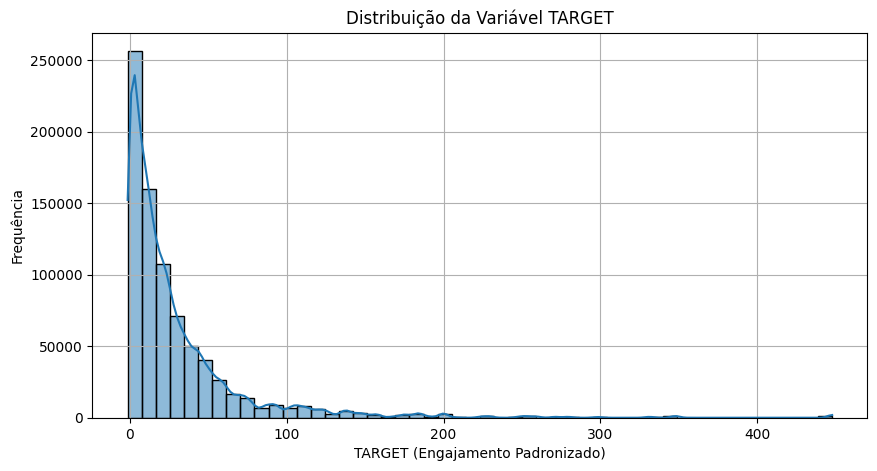

In [11]:
plot_target_distribution(target_df)

In [12]:
TARGET_INIT_COLS = [
    "userId", 
    "pageId",
    "numberOfClicksHistory",
    "timeOnPageHistory",
    "coldStart",
    "scrollPercentageHistory",
    "minutesSinceLastVisit",
    "timeGapDays"
]

TARGET_FINAL_COLS = [
    "userId", 
    "pageId",
    "TARGET"
]

In [13]:
def preprocess_target(
    df_users: pd.DataFrame,
    gap_df: pd.DataFrame
) -> pd.DataFrame:
    """Gera a coluna TARGET para medir engajamento por usuário/página, considerando o gap de tempo"""
    
    # Mescla os DataFrames com base em userId e pageId
    target_df = df_users.merge(gap_df, on=["userId", "pageId"])[TARGET_INIT_COLS]
    
    # Calcula um score base de engajamento usando as métricas históricas do usuário
    base_score = (
        target_df['numberOfClicksHistory']
        + (target_df['timeOnPageHistory'] / 500)
        + target_df['scrollPercentageHistory']
        - (target_df['minutesSinceLastVisit'] / 50)
    )
    
    # Fator multiplicativo que penaliza usuários que demoram muito para ver notícias (menos engajados)
    gap_factor = 1 / (1 + target_df['timeGapDays'])
    
    # Calcula o TARGET combinando o score base com o fator de gap
    target_df['TARGET'] = base_score * gap_factor
    
    # Padroniza TARGET utilizando robust scaling (subtrai a mediana e divide pelo IQR)
    median_val = target_df['TARGET'].median()
    iqr_val = target_df['TARGET'].quantile(0.75) - target_df['TARGET'].quantile(0.25)
    
    if iqr_val == 0:
        target_df['TARGET'] = target_df['TARGET'] - median_val
    else:
        target_df['TARGET'] = (target_df['TARGET'] - median_val) / iqr_val
    
    # Mantém só as colunas essenciais do dataframe de target
    target_df = target_df[TARGET_FINAL_COLS]
    
    return target_df

gap = pd.read_parquet("data/features/mix_feats/gap_feats.parquet")

target_new = preprocess_target(df_users, gap)
target_new

,userId,pageId,TARGET
0,00011b1ced626112372206634e0e9b5ccb432da916e83f...,c9b148e7-72fa-416e-84ac-a4499abc7aaf,-0.354646
1,00012cd490cea9fe043146807def18c830fa0d0b791772...,5a5e2555-ac88-4882-9dc2-e19bb392a448,8.666845
2,00012cd490cea9fe043146807def18c830fa0d0b791772...,3363b054-df39-4e3d-b2b3-dd3cb227dd55,-0.076096
3,00012cd490cea9fe043146807def18c830fa0d0b791772...,e81de120-5005-4a01-8b63-90018005903e,-0.348626
4,00024d84a3d619b1972e9dd5efa9c930557d85f6463fd6...,c274ed4b-e679-41ce-9dfb-c53874916511,-0.335565
...,...,...,...
474665,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,fb5459eb-d86b-447e-83d5-0172fbab1ecd,-0.166146
474666,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,2e3300c6-3a18-4908-b9a9-a955cfcdcfcc,-0.313386
474667,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,1ca0b64a-8bb4-4a2b-b3d0-af935960bf15,-0.329151
474668,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,331bc28e-4e05-425e-8914-766606dfdf88,-0.352126


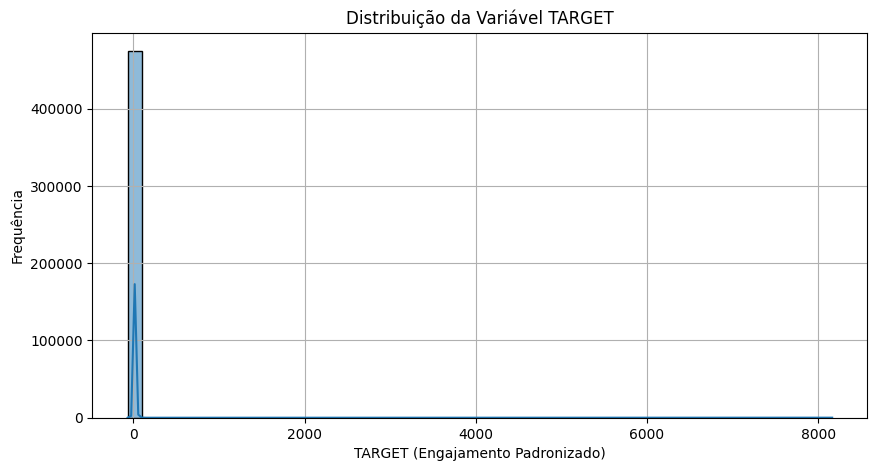

In [14]:
plot_target_distribution(target_new)

In [ ]:
SCALING_RANGE = 1000

import numpy as np
import pandas as pd

def preprocess_target(df_users: pd.DataFrame, gap_df: pd.DataFrame) -> pd.DataFrame:
    """
    Gera a coluna TARGET para medir o engajamento por par (usuário/página) com maior variância.
    
    O pipeline inclui:
      1. Merge entre df_users e gap_df.
      2. Cálculo de componentes do score base (clicks, tempo, scroll, recency), com pesos ajustados e tratamento de NAs.
      3. Aplicação de fatores de histórico e gap de tempo.
      4. Transformação logarítmica (opcional).
      5. Escalonamento MinMax para um range [0, 100].
    
    Args:
        df_users (pd.DataFrame): DataFrame com informações de usuários.
        gap_df (pd.DataFrame): DataFrame com colunas de gap temporal.

    Returns:
        pd.DataFrame: DataFrame contendo as colunas essenciais do TARGET.
    """

    # Exemplo de colunas que você quer no final
    TARGET_INIT_COLS = [
        "userId", "pageId",
        "numberOfClicksHistory", "timeOnPageHistory", "scrollPercentageHistory",
        "minutesSinceLastVisit", "historySize", "timeGapDays"
    ]
    TARGET_FINAL_COLS = ["userId", "pageId", "TARGET"]

    # 1. Mescla DataFrames com base em userId e pageId.
    target_df = df_users.merge(gap_df, on=["userId", "pageId"], how="left")[TARGET_INIT_COLS].copy()

    # 2. Tratamento de valores ausentes: definir valores padrão
    default_values = {
        "numberOfClicksHistory": 0,
        "timeOnPageHistory": 0,          # em milissegundos
        "scrollPercentageHistory": 0,
        "minutesSinceLastVisit": 60,     # default de 60 minutos
        "historySize": 130,             # média aproximada
        "timeGapDays": 50               # valor arbitrário para gap de tempo
    }
    for col, default in default_values.items():
        if col in target_df.columns:
            target_df[col] = target_df[col].fillna(default)

    # 3. Cálculo do score base
    #    Ajuste os pesos conforme o que fizer sentido para o seu problema
    clicks_component = 1.0 * target_df["numberOfClicksHistory"]
    time_component   = 2.0 * (target_df["timeOnPageHistory"] / 1000)  # aumentar peso do tempo
    scroll_component = 1.5 * target_df["scrollPercentageHistory"]     # aumentar peso do scroll
    recency_penalty  = 0.5 * (target_df["minutesSinceLastVisit"] / 60)

    base_score = (clicks_component + time_component + scroll_component) - recency_penalty

    # Fator de histórico (normalizado pela média ~130)
    history_factor = target_df["historySize"] / 130

    # Fator penalizador para o gap de tempo (quanto menor o gap, maior o score)
    gap_factor = 1 / (1 + target_df["timeGapDays"] / 50)

    # Combina componentes e fatores
    raw_score = base_score * history_factor * gap_factor

    # Se o score ficar negativo, podemos forçar a zero para evitar problemas no log
    raw_score = np.maximum(raw_score, 0)

    # 4. Transformação logarítmica para aumentar variância
    #    (opcional, mas ajuda a “espalhar” mais a distribuição)
    log_score = np.log1p(raw_score)  # log(1 + x)

    # 5. MinMax Scaling para [0, 100]
    min_val, max_val = log_score.min(), log_score.max()
    if max_val == min_val:
        # Se tudo for igual (caso extremo), define como zero
        scaled_score = log_score - min_val
    else:
        scaled_score = (log_score - min_val) / (max_val - min_val)

    # Escala para [0, 100]
    scaled_score = scaled_score * 100

    # Se quiser arredondar para inteiro, pode fazer:
    final_score = scaled_score.round().astype(int)

    # 6. Atribui ao DataFrame
    target_df["TARGET"] = final_score

    # 7. Retém apenas as colunas essenciais
    target_df = target_df[TARGET_FINAL_COLS]

    return target_df

target_new2 = preprocess_target(df_users, gap)
target_new2

,userId,pageId,TARGET
0,00011b1ced626112372206634e0e9b5ccb432da916e83f...,c9b148e7-72fa-416e-84ac-a4499abc7aaf,0
1,00012cd490cea9fe043146807def18c830fa0d0b791772...,5a5e2555-ac88-4882-9dc2-e19bb392a448,13
2,00012cd490cea9fe043146807def18c830fa0d0b791772...,3363b054-df39-4e3d-b2b3-dd3cb227dd55,10
3,00012cd490cea9fe043146807def18c830fa0d0b791772...,e81de120-5005-4a01-8b63-90018005903e,1
4,00024d84a3d619b1972e9dd5efa9c930557d85f6463fd6...,c274ed4b-e679-41ce-9dfb-c53874916511,1
...,...,...,...
808073,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,fb5459eb-d86b-447e-83d5-0172fbab1ecd,19
808074,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,2e3300c6-3a18-4908-b9a9-a955cfcdcfcc,20
808075,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,1ca0b64a-8bb4-4a2b-b3d0-af935960bf15,11
808076,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,331bc28e-4e05-425e-8914-766606dfdf88,5


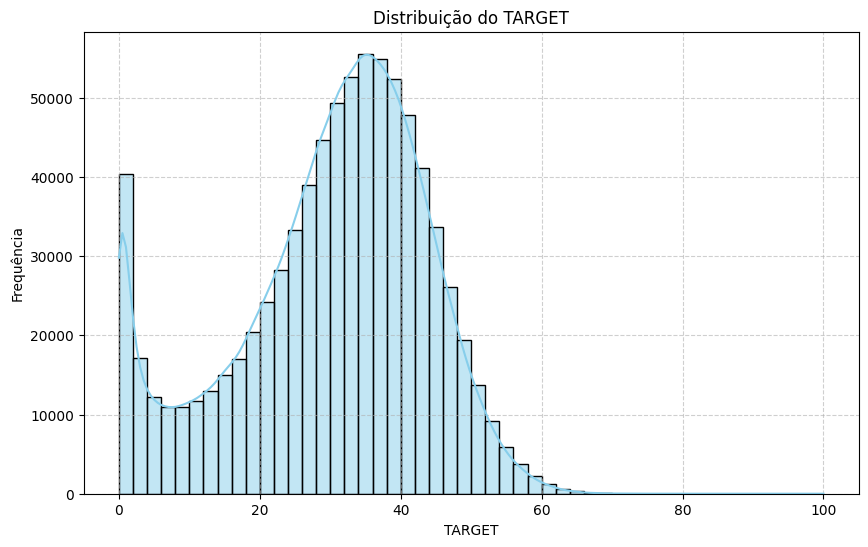

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))
sns.histplot(target_new2['TARGET'], kde=True, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribuição do TARGET')
plt.xlabel('TARGET')
plt.ylabel('Frequência')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
